# GANdy package uses demonstration
Status @ 03.15.21
***

In [1]:
import importlib

In [2]:
# imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection

import gandy.quality_est.datagen as gandy_datagen
import gandy.models.gps as gandy_gps
import gandy.models.bnns as gandy_bnns
import gandy.models.gans as gandy_gans
import gandy.optimization.hypersearch as gandy_opt

%matplotlib inline

***

In order to test our models on the ability to predict uncertainty, we synthesized test cases with known uncertainty functions. With these, we can compare the predicted uncertainties to the "true" value.

This was done foundationally as follows:

__Dataset 1__: 
- With some analytical function $f(x_1, x_2)$
- Introduce x dependant noise $g(x_1, x_2)$
- create a dataset of $y(x_1, x_2) = g + f$

__Dataset 2__:
- Repeat above but use QM9 molecular property data instead of an analytical function

## <span style="color:orange"> Loading and preparing the data</span>

In [3]:
df_analytical, noise = gandy_datagen.generate_analytical_data(to_csv=False)
df_analytical.describe()

,X1,X2,Y
count,10000.000000,10000.000000,10000.000000
mean,4.972780,5.002463,14.947380
std,2.873060,2.884472,6.504276
min,0.001129,0.002807,0.249216
25%,2.474712,2.521442,9.842054
50%,4.968011,4.986059,14.989668
75%,7.440366,7.484527,19.873525
max,9.998766,9.999040,35.938624


>The data is 2 dimensional in features and one in targets.

<span style="color:red"> NOTE: CHANGED THE ANALYTICAL GENERATION SLIGHTLY TO HAVE A BETTER/MORE INTERPERATBLE DATASET (lower sample range, more points, less noise magnitude. was pretty much all noise before)</span>

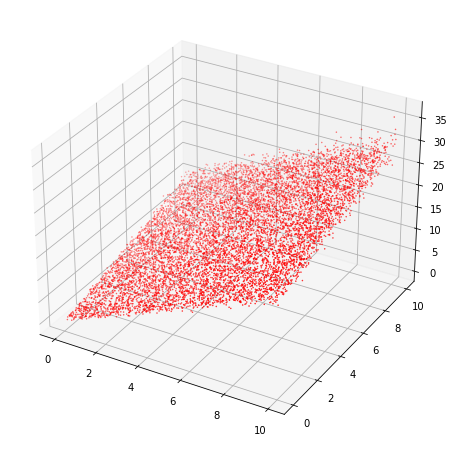

In [4]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_analytical['X1'], df_analytical['X2'], df_analytical['Y'], marker='.', color='r', s=1)
plt.show()

> The underlying analytical functions are planwaves, and we see an increase in noise as either X feature gets larger. We would like to reproduce this noise as uncertainty with our models.

In [5]:
## prepare the data as arrays
Xs = df_analytical[['X1', 'X2']].values
Ys = df_analytical['Y'].values.reshape(-1,1)
#. split into train and test
Xsr, Xst, Ysr, Yst = sklearn.model_selection.train_test_split(Xs, Ys, train_size=0.97)

#. scale and normalize our data
norm = sklearn.preprocessing.Normalizer()
scale = sklearn.preprocessing.StandardScaler()
Xsr = norm.fit_transform(Xsr)
Xst = norm.transform(Xst)
# Ysr = scale.fit_transform(Ysr)
# Yst = scale.transform(Yst)

***

We then instatialize and train our models on these datasets. All models are built on the same class framework so follow the same procedure.

## <span style="color:orange">Gaussian processes</span>

In [6]:
# instantialize the model
gp = gandy_gps.ucGaussianProcess.R(xshape=Xsr.shape[1:],
                                   yshape=Ysr.shape[1:])

In [7]:
# train it on the training data
gp.train(Xsr, Ysr)

In [8]:
# make predictions
gp_preds, gp_uncs = gp.predict(Xst)

/Users/ek/miniconda3/envs/gandy_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


## <span style="color:orange"> Bayesian Neural Networks</span>

In [9]:
# instantialize the model
bnn = gandy_bnns.BNN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     train_size=len(Xsr))   # we must also pass the size of the training set, necessary for BNNs to weight the divergence

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [10]:
# train it on the training data
bnn.train(Xsr, Ysr, epochs=100)

Epoch 1/100
304/304 [==============================] - 2s 1ms/step - loss: 359.2560 - MSE: 284.6773
Epoch 2/100
304/304 [==============================] - 0s 1ms/step - loss: 75.3343 - MSE: 262.9307
Epoch 3/100
304/304 [==============================] - 0s 1ms/step - loss: 37.7918 - MSE: 245.0601
Epoch 4/100
304/304 [==============================] - 0s 1ms/step - loss: 23.5459 - MSE: 232.3237
Epoch 5/100
304/304 [==============================] - 0s 1ms/step - loss: 19.2818 - MSE: 218.3298
Epoch 6/100
304/304 [==============================] - 0s 1ms/step - loss: 14.1433 - MSE: 209.6035
Epoch 7/100
304/304 [==============================] - 0s 1ms/step - loss: 11.7625 - MSE: 196.0710
Epoch 8/100
304/304 [==============================] - 0s 1ms/step - loss: 10.4925 - MSE: 186.9971
Epoch 9/100
304/304 [==============================] - 0s 1ms/step - loss: 9.2234 - MSE: 178.5288
Epoch 10/100
304/304 [==============================] - 0s 1ms/step - loss: 8.2555 - MSE: 173.1464
Epoch 11/1

In [11]:
# make predictions
bnn_preds, bnn_uncs = bnn.predict(Xst)

## <span style="color:orange"> Generative Adversarial Networks</span>

In [12]:
# instantialize the model
gan = gandy_gans.GAN(xshape=Xsr.shape[1:],
                     yshape=Ysr.shape[1:],
                     learning_rate=1e-4)

/Users/ek/miniconda3/envs/gandy_env/lib/python3.7/site-packages/gandy/models/dcgan.py:100: UserWarning: learning_rate must start with generator_ or discriminator_
Passing learning_rate as deepchem model init kwargs.
  " model init kwargs.")


In [13]:
# train it on the training data
gan.train(Xsr, Ysr, batches=10000)

Step 1000: 	Avg gen loss 0.7858396760225296, 	Avg discrim loss 1.117794897556305
Step 2000: 	Avg gen loss 0.8143810874819756, 	Avg discrim loss 1.436270122885704
Step 3000: 	Avg gen loss 0.7175461018085479, 	Avg discrim loss 1.3539730017185212
Step 4000: 	Avg gen loss 0.7138964359760285, 	Avg discrim loss 1.3923510998487472
Step 5000: 	Avg gen loss 0.7084518533349037, 	Avg discrim loss 1.3773067138195039
Step 6000: 	Avg gen loss 0.7002400529384613, 	Avg discrim loss 1.3848579248189927
Step 7000: 	Avg gen loss 0.7045796946287155, 	Avg discrim loss 1.3765250773429871
Step 8000: 	Avg gen loss 0.7068886780142785, 	Avg discrim loss 1.3710258406400682
Step 9000: 	Avg gen loss 0.7086668889522553, 	Avg discrim loss 1.3684377576112747
Step 10000: 	Avg gen loss 0.7082081509232521, 	Avg discrim loss 1.368691836476326
TIMING: model fitting took 40.460 s


In [14]:
# make predictions
gan_preds, gan_uncs = gan.predict(Xst)

## <span style="color:orange"> Looking back at losses</span>

All of the models store any returned losses/metrics. These can be accessed at the `sessions` attribute for every training session, and additionally if the model accepts loss types other than default it can be specified to the model.

In [15]:
gan_losses = []
for key in gan.sessions.keys():
    gan_losses.append(gan.sessions[key])
    # only get one training session losses
    break
gan_losses = np.array(gan_losses[0])
gen_loss = gan_losses[0]
dis_loss = gan_losses[1]

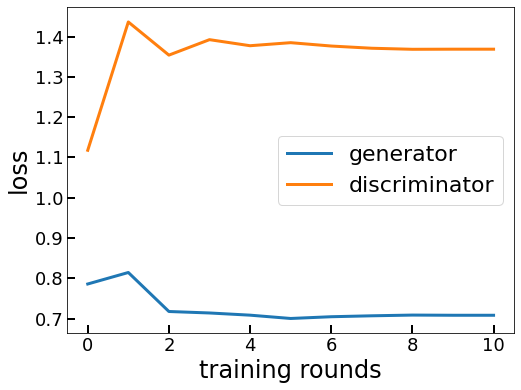

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

# plotting
ax.plot(gen_loss, linewidth=3, label='generator')
ax.plot(dis_loss, linewidth=3, label='discriminator')

# labels
ax.set_ylabel('loss', size=24)
ax.set_xlabel('training rounds', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

# legend
plt.legend(fontsize=22)

plt.show()

## <span style="color:orange"> Predictions</span>

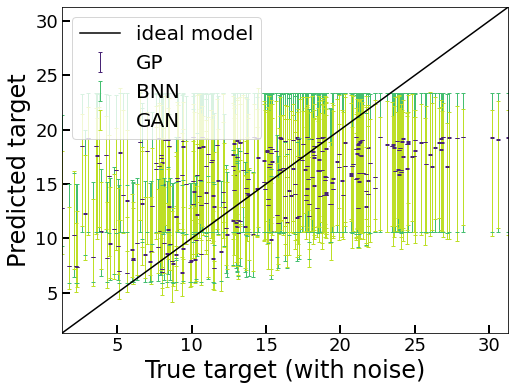

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

# set ax limits
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])

Colors = plt.cm.viridis([0.1, 0.7, 0.9])

# plot predictions of models
ax.errorbar(Yst, gp_preds, yerr=gp_uncs.reshape(-1), ls='none', label='GP', linewidth=1,
            capsize=2, c=Colors[0])
ax.errorbar(Yst, bnn_preds, yerr=bnn_uncs.reshape(-1), ls='none', label='BNN', linewidth=1,
            capsize=2, c=Colors[1])
ax.errorbar(Yst, gan_preds, yerr=gan_uncs.reshape(-1), ls='none', label='GAN', linewidth=1,
            capsize=2, c=Colors[2])

# perfect result
ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')

# labels
ax.set_ylabel('Predicted target', size=24)
ax.set_xlabel('True target (with noise)', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

plt.legend(fontsize=20)
plt.show()

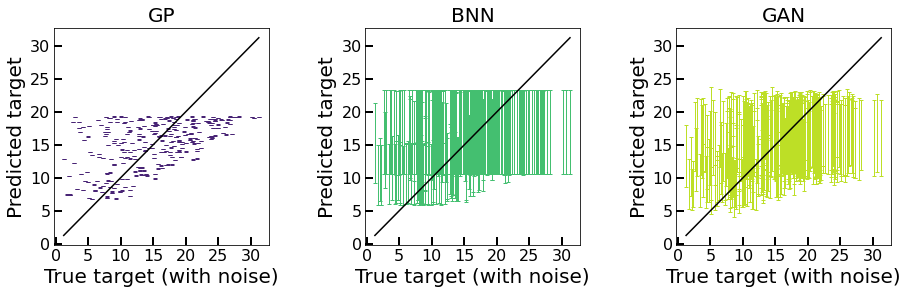

In [18]:
fig, axes = plt.subplots(figsize=(15,4), ncols=3)
fig.subplots_adjust(wspace=0.45)

# set ax limits
minv, maxv = Yst.min(), Yst.max()
ax.set_ylim([minv, maxv])
ax.set_xlim([minv, maxv])

Colors = plt.cm.viridis([0.1, 0.7, 0.9])
Preds = [gp_preds, bnn_preds, gan_preds]
Errs = [gp_uncs.reshape(-1), bnn_uncs.reshape(-1), gan_uncs.reshape(-1)]
Labels = ['GP', 'BNN', 'GAN']

# plot predictions of models
for i, ax in enumerate(axes):
    ax.errorbar(Yst, Preds[i], yerr=Errs[i], ls='none', label=Labels[i], linewidth=1,
            capsize=2, c=Colors[i])
    
    # perfect result
    ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')
    
    # labels
    ax.set_ylabel('Predicted target', size=20)
    ax.set_xlabel('True target (with noise)', size=20)

    # format ticks
    plt.setp(ax.get_xticklabels(), fontsize=16)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(direction='in', width=2, length=8)   

    ax.set_title(f'{Labels[i]}', fontsize=20)
    
plt.show()

All of the models at a galance to pretty poorly!

__GP__: The predicted values are mostly stationary. This is fairly expected given that we have only two features and a very nonlinear function. It also is predicting 0 uncertianty for most quantities.

__BNN__: Something seems very off here, the model predicts the same quantiy and uncertainty for all values.

__GAN__: The model seems to be on track knowing the fickyness of GANs. Also by the descriminator and generator losses diverging we can tell that we need to change some hyperparameters.

***

It might also be desireable to conduct hyperparameter search over a given model type's hyperparameters. This is achieved with the an optimization routine using [Optuna](https://github.com/optuna/optuna)'s code wrapped to fit our Uncertainty Model class.

## <span style="color:orange">Running a hyperparameter optimization</span>

Search for BNN hyperparameters - activation function and learning rate

In [24]:
# and the optimizing routine
# define the search space
search_space = {'activation': ['tanh', 'relu', 'sigmoid'],               # signifies a choice
                'optimizer_learning_rate': (0.001, 0.1, 'loguniform')}    # a continues lognormal sample space

# and the optimizing routine
opt = gandy_opt.OptRoutine(subject=gandy_bnns.BNN,
                           Xs=Xsr,
                           Ys=Ysr,
                           search_space=search_space,
                           xshape=Xsr.shape[1:],
                           yshape=Ysr.shape[1:],
                           train_size=len(Xsr),
                           metric='MSE',
                           epochs=100)

In [25]:
# run the optimization
opt.optimize(n_trials=10)

[I 2021-03-15 14:38:49,001] A new study created in memory with name: no-name-f5accef5-bb53-46fb-80f8-3b2f0ad5220b


Cannot have more than one k, val_data, val_frac. Deleting k
Cannot have more than one k, val_data, val_frac.  Deleting val_data
<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.00620943084363995}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 272.5434 - MSE: 236.9001
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 17.8625 - MSE: 189.0850
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 10.3827 - MSE: 165.5221
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 7.3455 - MSE: 140.4326
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 6.0693 - MSE: 124.8656
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 5.1593 - MSE: 113.8906
Epoch 7/100

[I 2021-03-15 14:39:16,477] Trial 0 finished with value: 33.76129849644317 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.00620943084363995}. Best is trial 0 with value: 33.76129849644317.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'relu', 'optimizer_learning_rate': 0.005575165988804432}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: nan - MSE: nan                
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 8/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: n

[W 2021-03-15 14:39:43,912] Trial 1 failed, because the objective function returned nan.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'tanh', 'optimizer_learning_rate': 0.0016834248246315343}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 1012.0575 - MSE: 262.0438
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 352.1120 - MSE: 265.9125
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 231.4857 - MSE: 268.7265
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 196.2787 - MSE: 261.7064
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 178.3822 - MSE: 257.2163
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 135.1867 - MSE: 257.8917
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 118.8674 - MSE: 252.2068
Epoch 8/100
243/243 [==========

[I 2021-03-15 14:40:11,543] Trial 2 finished with value: 46.85261044848747 and parameters: {'activation': 'tanh', 'optimizer_learning_rate': 0.0016834248246315343}. Best is trial 0 with value: 33.76129849644317.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'tanh', 'optimizer_learning_rate': 0.003990598833898802}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 601.9082 - MSE: 268.9839
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 248.7997 - MSE: 258.5787
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 126.4726 - MSE: 257.5472
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 108.9354 - MSE: 261.8781
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 86.1785 - MSE: 257.6929
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 77.2453 - MSE: 247.0008
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 64.5792 - MSE: 241.9448
Epoch 8/100
243/243 [===============

[I 2021-03-15 14:40:39,399] Trial 3 finished with value: 41.15965253339304 and parameters: {'activation': 'tanh', 'optimizer_learning_rate': 0.003990598833898802}. Best is trial 0 with value: 33.76129849644317.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'relu', 'optimizer_learning_rate': 0.0014349653015019968}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 43401.9636 - MSE: 272.5541
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 1748668.1418 - MSE: 265.4537
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 166897.4732 - MSE: 259.0279
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 151270533937.0360 - MSE: 274.8774
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 430.6727 - MSE: 273.9425
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 6369.9913 - MSE: 280.4319
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 413.3437 - MSE: 287.6658
Epoch 8/100
2

[I 2021-03-15 14:41:06,996] Trial 4 finished with value: 145.18472740947445 and parameters: {'activation': 'relu', 'optimizer_learning_rate': 0.0014349653015019968}. Best is trial 0 with value: 33.76129849644317.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'relu', 'optimizer_learning_rate': 0.07459495383208745}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: nan - MSE: nan                  
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 8/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: 

[W 2021-03-15 14:41:34,562] Trial 5 failed, because the objective function returned nan.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.002545587945464056}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 144.1683 - MSE: 236.2041
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 20.3337 - MSE: 205.2253
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 10.9257 - MSE: 181.1702
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 8.1873 - MSE: 166.8809
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 6.6443 - MSE: 149.4769
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 5.5225 - MSE: 134.4402
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 4.9050 - MSE: 122.9316
Epoch 8/100
243/243 [===================

[I 2021-03-15 14:42:02,220] Trial 6 finished with value: 34.69798248453731 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.002545587945464056}. Best is trial 0 with value: 33.76129849644317.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'relu', 'optimizer_learning_rate': 0.019160498822533553}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: nan - MSE: nan     
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 8/100
243/243 [==============================] - 0s 1ms/step - loss: nan - MSE: nan
Epoch 9/

[I 2021-03-15 14:42:29,787] Trial 7 pruned. 


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.05000488993872056}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 13.1948 - MSE: 175.4777
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 3.7562 - MSE: 125.6542
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 3.6557 - MSE: 118.5740
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 3.6107 - MSE: 104.9823
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 3.6127 - MSE: 105.1184
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 3.5997 - MSE: 98.2843
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 3.5881 - MSE: 98.3018
Epoch 8/100
243/243 [=========================

[I 2021-03-15 14:42:57,336] Trial 8 finished with value: 42.305805303185586 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.05000488993872056}. Best is trial 0 with value: 33.76129849644317.


<function Trial.suggest_categorical at 0x1ca290170>
<function Trial.suggest_loguniform at 0x1ca28bf80>
{'activation': 'sigmoid', 'optimizer_learning_rate': 0.0011690913533937862}
metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
243/243 [==============================] - 2s 1ms/step - loss: 1774.7970 - MSE: 262.5487
Epoch 2/100
243/243 [==============================] - 0s 1ms/step - loss: 290.0806 - MSE: 243.6191
Epoch 3/100
243/243 [==============================] - 0s 1ms/step - loss: 164.9918 - MSE: 232.4646
Epoch 4/100
243/243 [==============================] - 0s 1ms/step - loss: 101.0475 - MSE: 221.9548
Epoch 5/100
243/243 [==============================] - 0s 1ms/step - loss: 72.7442 - MSE: 212.9527
Epoch 6/100
243/243 [==============================] - 0s 1ms/step - loss: 53.1839 - MSE: 204.0469
Epoch 7/100
243/243 [==============================] - 0s 1ms/step - loss: 45.7660 - MSE: 202.7067
Epoch 8/100
243/243 [==========

[I 2021-03-15 14:43:25,050] Trial 9 finished with value: 41.65048153524639 and parameters: {'activation': 'sigmoid', 'optimizer_learning_rate': 0.0011690913533937862}. Best is trial 0 with value: 33.76129849644317.


33.76129849644317

In [26]:
# what were the best parameters?
opt.best_params

{'activation': 'sigmoid', 'optimizer_learning_rate': 0.00620943084363995}

In [28]:
# train the best model
best_bnn = opt.train_best()

metric is not a valid hyperparamter, ignoring
epochs is not a valid hyperparamter, ignoring
Epoch 1/100
304/304 [==============================] - 2s 1ms/step - loss: 140.5013 - MSE: 215.7962
Epoch 2/100
304/304 [==============================] - 0s 1ms/step - loss: 11.3323 - MSE: 159.3494
Epoch 3/100
304/304 [==============================] - 0s 1ms/step - loss: 5.7732 - MSE: 126.8113
Epoch 4/100
304/304 [==============================] - 0s 1ms/step - loss: 4.7593 - MSE: 106.6420
Epoch 5/100
304/304 [==============================] - 0s 1ms/step - loss: 4.0811 - MSE: 93.3200
Epoch 6/100
304/304 [==============================] - 0s 1ms/step - loss: 3.7881 - MSE: 85.3965
Epoch 7/100
304/304 [==============================] - 0s 1ms/step - loss: 3.5451 - MSE: 78.9809
Epoch 8/100
304/304 [==============================] - 0s 1ms/step - loss: 3.4554 - MSE: 78.1892
Epoch 9/100
304/304 [==============================] - 0s 1ms/step - loss: 3.3896 - MSE: 76.7750
Epoch 10/100
304/304 [======

`best_bnn` is the BNN model with the best parameters found from the search.

***

Finally, we want to evaluate our model on its ability to predict uncertainty, such that future predictions of uncertainty are trusted. The UCP metric tests whether the uncertainty captures the true value.

## <span style="color:orange">Using an uncertainty metric</span>

In [34]:
UCP_gp, _ = gp.score(Xst, Yst, metric='UCP')
UCP_bnn, _ = bnn.score(Xst, Yst, metric='UCP')
UCP_gan, _ = gan.score(Xst, Yst, metric='UCP')

/Users/ek/miniconda3/envs/gandy_env/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [35]:
print('GP score: ', UCP_gp)
print('BNN score: ', UCP_bnn)
print('GAN score: ', UCP_gan)

GP score:  0.0
BNN score:  0.6333333333333334
GAN score:  0.64


The GAN seems to be performing the best, barely, but none of the models are predicting very well, and need to eb optimized. 